In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
import folium
from sklearn.metrics import r2_score
import geopy.distance as geo

# Creating our final dataset -details
flipping houses, analyzing the relationship between features and price to understand to create model that can determine which homes are being underestimated in price, and can be flipped to yield miore profit. Here we explore our first steps by creating our final data set

# In this notebook: FE and Cleaning
- cleaning dataset:  remove outliers 3 standard deviations, removing duplicates that have already been flipped
- engineering features based on waterfront and  binning zip code

# 1) Isolating the homes that have already been flipped
taking a look at our data set, we found that 17homes have been flipped in 2014-2015 span of our data. We choose to remove these as isolated cases of house-flipping to examine and better inform our analysis.

In [3]:
#read the data into a pandas dataframe
df = pd.read_csv("data/kc_house_data.csv")

### Creating the dataframe of resales
By only looking home ids that appear more than once, since each id entry represents a sale, this means these are the houses that were sold at least twice in a 2 year span, thus we conclude they were flipped

In [4]:
#Counting id appearances and isolating duplicates
id_counts = df['id'].value_counts()
id_counts_dupes =id_counts[id_counts > 1].index

#creating a dataframe comprised of only these duplicated ids
resales_df = df[df['id'].isin(list(id_counts_dupes))]
resales_df.info() #checking the basic info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 93 to 21565
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             353 non-null    int64  
 1   date           353 non-null    object 
 2   price          353 non-null    float64
 3   bedrooms       353 non-null    int64  
 4   bathrooms      353 non-null    float64
 5   sqft_living    353 non-null    int64  
 6   sqft_lot       353 non-null    int64  
 7   floors         353 non-null    float64
 8   waterfront     307 non-null    object 
 9   view           353 non-null    object 
 10  condition      353 non-null    object 
 11  grade          353 non-null    object 
 12  sqft_above     353 non-null    int64  
 13  sqft_basement  353 non-null    object 
 14  yr_built       353 non-null    int64  
 15  yr_renovated   286 non-null    float64
 16  zipcode        353 non-null    int64  
 17  lat            353 non-null    float64
 18  long   

In [ ]:
#sorting the dataset by id so that the earlier sale is on top
resales_df = resales_df.sort_values(['id','date'])
resales_df.describe()

### looking at resale profit
by sorting the dataset like above, we can be sure that the difference in sale price is the later sale date - earlier sale date when grouped below and taking the difference

In [8]:
#grouping by id and taking the difference to examine house-flip profits
resale_profit = resales_df.groupby('id')[['price']].diff().dropna()

### obtaining resale profit metrics
below we see that a total of 177 homes were flipped from our data along with other standard metrics. additionally we looked at the median

In [10]:
resale_profit.describe()

,price
count,177.000000
mean,135796.050847
std,100596.854338
min,-40000.000000
25%,65000.000000
50%,115450.000000
75%,199000.000000
max,529950.000000


In [11]:
resale_profit.median()

price    115450.0
dtype: float64

our median is close to the mean so it suggests a somewhat normal distribution. on to visualization
## Visualizing the resale profit

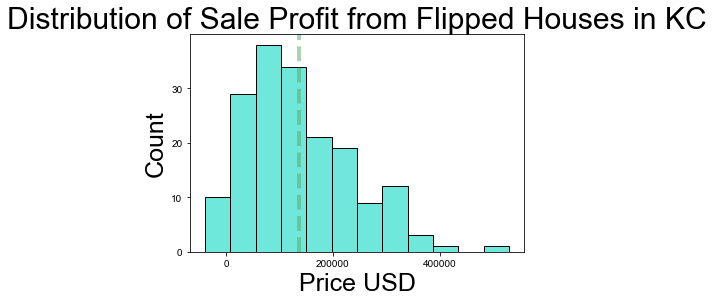

In [12]:
p = sns.histplot(resale_profit['price'].dropna(), color = 'turquoise')
sns.set(style = 'white', font_scale = 2)
p.set_title('Distribution of Sale Profit from Flipped Houses in KC', fontsize = 30)
p.set_xlabel('Price USD', fontsize = 25)
p.set_ylabel('Count', fontsize = 25)
p.axvline(resale_profit['price'].dropna().mean(), color = 'g', linestyle = "--", lw = 4, alpha = 0.5)

 # 2) Binning into Urban, Suburban, Rural by Zipcode, then applying OHE

In [4]:
pd.set_option('display.max_rows', 100)
df.zipcode.value_counts()

98103    602
98038    589
98115    583
98052    574
98117    553
98042    547
98034    545
98118    507
98023    499
98006    498
98133    493
98059    468
98058    455
98155    446
98074    441
98033    432
98027    412
98125    409
98056    406
98053    403
98001    361
98075    359
98126    354
98092    351
98144    343
98106    335
98116    330
98029    321
98199    317
98004    317
98065    308
98122    290
98146    288
98028    283
98008    283
98040    282
98198    280
98003    280
98072    273
98031    273
98112    269
98168    269
98055    268
98107    266
98136    263
98178    262
98030    256
98177    255
98166    254
98022    233
98105    229
98045    220
98002    199
98077    198
98011    195
98019    190
98108    186
98119    184
98005    168
98007    141
98188    136
98032    125
98014    124
98070    117
98109    109
98102    104
98010    100
98024     80
98148     57
98039     50
Name: zipcode, dtype: int64

In [5]:
def label_zip (row):
    if row['zipcode'] in [98101,98102,98103,98104,98105,98106,98107,98108, 98109, 98112,98115,98117,98118,98119,98136,98116,98126,98144,98134,98121,98122,98125, 98133,98199,98195]:
        return 'urban'
    if row['zipcode'] in [98019,98014,98024,98065,98051,98022,98045,98288,98224,98070]:
        return 'rural'
    if row['zipcode'] in [98055,98177, 98155,98028,98011,98034,98072,98077,98052,98033,98039,98040,98004,98005,98007,98008,98006,98056,98057,98178,98146,98168,98166,98148,98158,98188,98198,98023,98001,98003,98032,98031,98030,98047,98002,98092,98042,98058,98059,98075,98074,98029,98027,98038,98010,98053]:
        return 'suburban'
    return 'etc'

df['label'] = df.apply(lambda row: label_zip(row), axis=1)

df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,label
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,suburban
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,urban
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,suburban
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,urban
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,suburban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,urban
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,suburban
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,urban
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,suburban


In [6]:
ohe_df = pd.get_dummies(df, columns = ['label'])
ohe_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,label_rural,label_suburban,label_urban
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,0,1,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,0,0,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,0,1,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,0,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,0,1,0


In [7]:
ohe_df.to_csv('data/ohe_zip_data.csv')

 # 3) Binning into Regions using Lat, Long, then applying OHE

In [8]:
df['group']=np.where((df.lat <= 47.3333333) & (df.long <= -122.133333),'SW',
    np.where((df.lat <= 47.3333333) & (df.long <= -121.666667),'S',
    np.where((df.lat <= 47.3333333) & (df.long <= -121.2),'SE',
    np.where((df.lat <= 47.5666667) & (df.long <= -122.133333),'W',
    np.where((df.lat <= 47.5666667) & (df.long <= -121.666667),'C',
    np.where((df.lat <= 47.5666667) & (df.long <= -121.2),'E',
    np.where((df.lat <= 47.8) & (df.long <= -122.133333),'NW',
    np.where((df.lat <= 47.8) & (df.long <= -121.666667),'N',
    np.where((df.lat <= 47.8) & (df.long <= -121.2),'NE',
             'others')))))))))

In [9]:
df.group.value_counts()

NW    8383
W     6152
N     2746
C     2613
SW    1308
S      377
NE      16
SE       1
E        1
Name: group, dtype: int64

In [10]:
ohe_df2 = pd.get_dummies(df, columns = ['group'])
ohe_df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,label,group_C,group_E,group_N,group_NE,group_NW,group_S,group_SE,group_SW,group_W
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,suburban,0,0,0,0,0,0,0,0,1
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,urban,0,0,0,0,1,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,suburban,0,0,0,0,1,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,urban,0,0,0,0,0,0,0,0,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,suburban,0,0,1,0,0,0,0,0,0


In [11]:
ohe_df2.to_csv('data/ohe_region_data.csv')

# 4) Data Cleaning: Outlier removal
with duplicates removed and isolated, we proceeded to remove outliers that were greater than 3 standard deviations away from the mean on most of the numerical variables except our target variable price.

In [5]:
#reading the dupes-free and categorical var encoded data (see link above)
df = pd.read_csv('data/ohe_zip_data.csv')
df.drop('Unnamed: 0', axis = 1, inplace=True)

In [7]:
#inspecting the data
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,label_rural,label_suburban,label_urban
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,0,1,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,0,0,1


In [8]:
#checking the nature of our data columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              21420 non-null  int64  
 1   date            21420 non-null  object 
 2   price           21420 non-null  float64
 3   bedrooms        21420 non-null  int64  
 4   bathrooms       21420 non-null  float64
 5   sqft_living     21420 non-null  int64  
 6   sqft_lot        21420 non-null  int64  
 7   floors          21420 non-null  float64
 8   waterfront      19067 non-null  object 
 9   view            21357 non-null  object 
 10  condition       21420 non-null  object 
 11  grade           21420 non-null  int64  
 12  sqft_above      21420 non-null  int64  
 13  sqft_basement   21420 non-null  object 
 14  yr_built        21420 non-null  int64  
 15  yr_renovated    17616 non-null  float64
 16  zipcode         21420 non-null  int64  
 17  lat             21420 non-null 

above we see that this only includes some of the features engineered and binned by zipcode, we will add the others after removing outliers
### Removing outliers 3 STD away

In [11]:
#Choosing the columns to remove outliers on.
outlier_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for col in outlier_columns:
    df_filtered_std = df[((df[col] - df[col].mean()) / df[col].std()).abs() < 3]
df_filtered_std.shape

(21059, 24)

In [12]:
#writing down this cleaned data for safe-keeping
df_filtered_std.to_csv('data/df_no_oultliers.csv')

# 5) Feature engineering distance to waterfront
## Creating a coordinates column from latitude and longitude

In [13]:
df_water = df_filtered_std.copy() # making a copy to add features to

#creating a coordinates column with both coordinates
df_water['coordinates'] = pd.Series([(x,y) for x, y in df_water[['lat', 'long']].values])

In [15]:
#verifying the creation of coordinates column
df_water.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,label_rural,label_suburban,label_urban,coordinates
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,98178,47.5112,-122.257,1340,5650,0,1,0,"(47.5112, -122.257)"
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1991.0,98125,47.7210,-122.319,1690,7639,0,0,1,"(47.721, -122.319)"


## Creating a function that maps distance to waterfront view

In [22]:
#First create the list of waterfront coordinates
water_view_df = df[df['waterfront'] =='YES']


utilizing the latitude and longitude, and the combined coordinates, we below engineer a function that return the distance to the nearest waterfront property, giving us a rough picture of all the properties' distance to water 

In [17]:
#defining the function that gives the minimum distance to a waterfront property 
def closest_water(coor_1):
    dist_list = []
    for row in df:
        for x, y  in water_view_df[['lat', 'long']].values:
            coor_2 = (x,y)
            distance = geo.distance(coor_1, coor_2)
            dist_list.append(distance)
        return min(dist_list)

### mapping the function to the dataframe

In [ ]:
#applying the newly created
df_water.loc[:, 'closest_water'] = df_water.loc[:,'coordinates'].map(closest_water)

mapping takes almost 10 minutes so we immediately save this down
### saving our master data set

In [25]:
df_water.to_csv('data/master_data.csv')

# 6) Cleaning and removing duplicates from the OHE dataframe with region groups and merging into final data set
before we add in the final features, we need to remove duplicates and outliers the same way we did above

In [56]:
#reading that file into a new dataframe
ohe_region_df = pd.read_csv('ohe_region_data.csv')

In [59]:
#dropping duplicates and verifying success by checking the shape
ohe_region_df.drop_duplicates(subset = 'id', inplace = True)
ohe_region_df.shape

(21420, 32)

In [60]:
#Choosing the columns to remove outliers in the same way as above
outlier_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for col in outlier_columns:
    ohe_filtered_std = ohe_region_df[((ohe_region_df[col] - ohe_region_df[col].mean()) / ohe_region_df[col].std()).abs() < 3]
ohe_filtered_std.shape

(21059, 32)

### Final merge for master data file

In [65]:
#choosing only the new variables to add
ohe_for_merge = ohe_filtered_std[['group_C', 'group_E', 'group_N', 'group_NE', 'group_NW', 'group_S',
       'group_SE', 'group_SW', 'group_W']]

In [67]:
#combining the data
final_data= pd.concat([df_water, ohe_for_merge])

In [68]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42118 entries, 0 to 21596
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              21059 non-null  float64
 1   date            21059 non-null  object 
 2   price           21059 non-null  float64
 3   bedrooms        21059 non-null  float64
 4   bathrooms       21059 non-null  float64
 5   sqft_living     21059 non-null  float64
 6   sqft_lot        21059 non-null  float64
 7   floors          21059 non-null  float64
 8   waterfront      18748 non-null  object 
 9   view            20998 non-null  object 
 10  condition       21059 non-null  object 
 11  grade           21059 non-null  float64
 12  sqft_above      21059 non-null  float64
 13  sqft_basement   21059 non-null  object 
 14  yr_built        21059 non-null  float64
 15  yr_renovated    17306 non-null  float64
 16  zipcode         21059 non-null  float64
 17  lat             21059 non-null 

In [ ]:
#re-writing our master data for our analysis
final_data.to_csv('master_data.csv')